<a href="https://colab.research.google.com/github/suriya-mouli/Alzheimer-s_Disease_Prediction/blob/main/Alzheimer's_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: Install & Import Libraries

!pip install split-folders tensorflow scikit-learn matplotlib seaborn

import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
# STEP 2: Mount Drive & Setup
#
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/augmented__ADNI'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# STEP 3: Split Dataset (70% Train, 15% Val, 15% Test)

output_dir = '/content/alzheimer_split'
splitfolders.ratio(dataset_path, output=output_dir, seed=42, ratio=(0.7, 0.15, 0.15))

train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

Copying files: 14000 files [04:20, 53.66 files/s] 


In [5]:
# STEP 4: Data Preprocessing

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size (InceptionV3 expects 299x299)
IMG_SIZE = (299, 299)

# Create image generators (no augmentation since dataset is already augmented)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load train, val, test images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 9800 images belonging to 4 classes.
Found 2100 images belonging to 4 classes.
Found 2100 images belonging to 4 classes.


In [6]:
# STEP 5: Feature Extraction with InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Freeze convolutional base
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# STEP 6: Compile Model

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# STEP 7: Train Model (30 Epochs)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


307/307 ━━━━━━━━━━━━━━━━━━━━ 85s 209ms/step - accuracy: 0.4030 - loss: 1.3058 - val_accuracy: 0.6129 - val_loss: 0.9133
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 45s 148ms/step - accuracy: 0.5391 - loss: 1.0377 - val_accuracy: 0.6462 - val_loss: 0.8390
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - accuracy: 0.5665 - loss: 0.9748 - val_accuracy: 0.6476 - val_loss: 0.8085
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 44s 143ms/step - accuracy: 0.5961 - loss: 0.9022 - val_accuracy: 0.6481 - val_loss: 0.8123
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 44s 144ms/step - accuracy: 0.5946 - loss: 0.9105 - val_accuracy: 0.6590 - val_loss: 0.7774
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.6148 - loss: 0.8733 - val_accuracy: 0.6652 - val_loss: 0.7632
Epoch 7/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 44s 144ms/step - accuracy: 0.6294 - loss: 0.8487 - val_accuracy: 0.6748 - val_loss: 0.7413
Epoch 8/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 44s 144ms/step - accuracy: 0.6174 - loss: 0.8626 - val

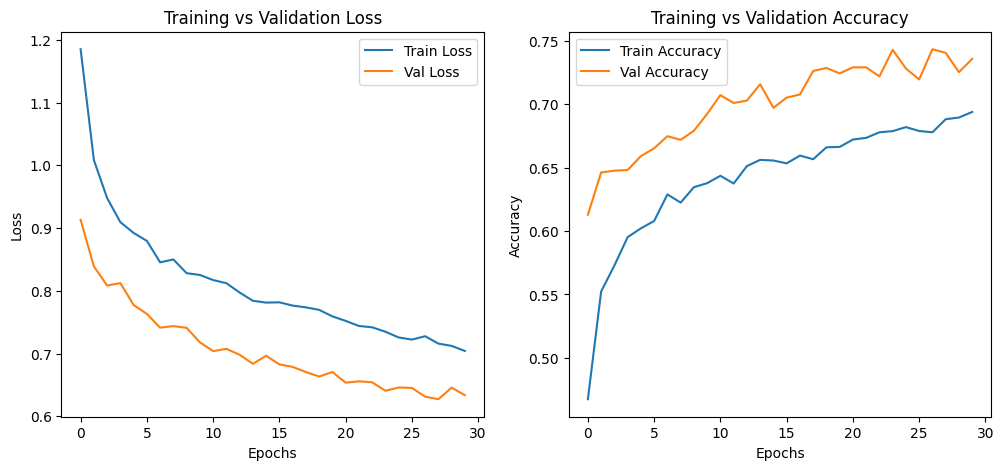

In [9]:
# STEP 8: Plot Training vs Validation Metrics

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# STEP 9: Model Evaluation on Test Set

test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.7395 - loss: 0.6464

Test Loss: 0.6458
Test Accuracy: 0.7310


In [11]:
# STEP 10: Predictions and Metrics

y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step


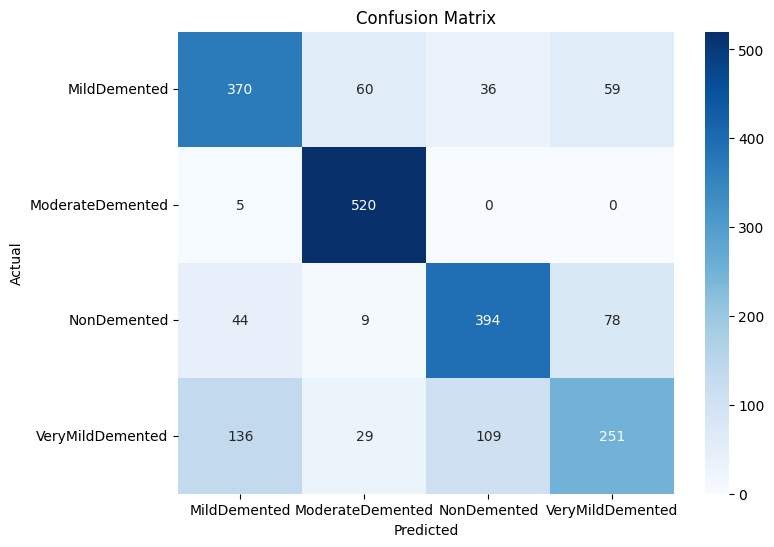

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Precision, Recall, F1-score
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))



Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.67      0.70      0.69       525
ModerateDemented       0.84      0.99      0.91       525
     NonDemented       0.73      0.75      0.74       525
VeryMildDemented       0.65      0.48      0.55       525

        accuracy                           0.73      2100
       macro avg       0.72      0.73      0.72      2100
    weighted avg       0.72      0.73      0.72      2100



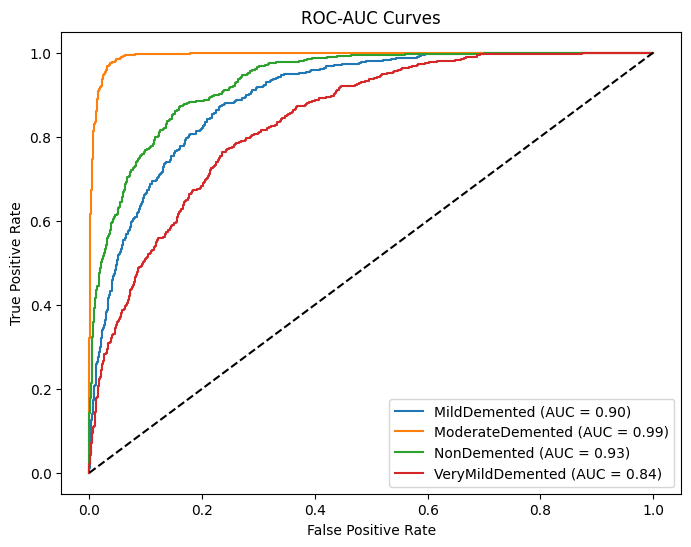

In [14]:
# ROC-AUC
plt.figure(figsize=(8,6))
for i, class_name in enumerate(test_generator.class_indices.keys()):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves')
plt.legend()
plt.show()


In [15]:
# Log Loss
logloss_value = log_loss(y_true, y_pred_prob)
print(f'\nLog Loss: {logloss_value:.4f}')


Log Loss: 0.6458


Class labels: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


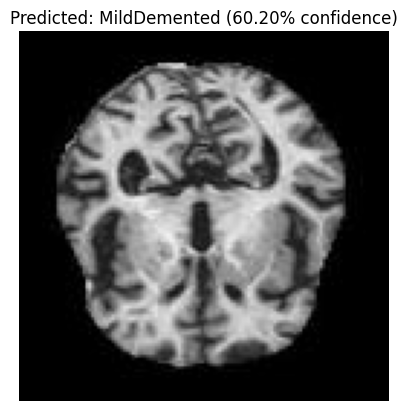

 Predicted Class: MildDemented
 Confidence: 60.20%
 Raw Output: [0.6019948  0.00286826 0.12146556 0.27367142]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Get the class names from your training generator
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

#  Define the function (this is the *definition*, not execution)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    predicted_label = class_labels[predicted_index]

    # Show image and result
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}% confidence)")
    plt.show()

    print(f" Predicted Class: {predicted_label}")
    print(f" Confidence: {confidence:.2f}%")
    print(f" Raw Output: {predictions[0]}")

#  Now call the function with your image path:
predict_image("/content/drive/MyDrive/augmented__ADNI/MildDemented/1 (15).jpg")
